In [38]:
import socket
import struct
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
import glob, os

In [39]:
tdrDir = '/Users/HHG/FilesRepositories/AEDAT/WIM_try3/'
dataDir = tdrDir
os.chdir(dataDir)

data_list = glob.glob("*aedat")
data_readlist = []
for ind in data_list:
    data_readlist.append(open(ind, "rb"))
    debug = False

In [40]:
def read_events(file):
    """ A simple function that read dynap-se events from cAER aedat 3.0 file format"""
    
    # raise Exception at end of file
    data = file.read(28)
    if(len(data) <= 0):
        print("read all data\n")
        raise NameError('END OF DATA')


    # read header
    eventtype = struct.unpack('H', data[0:2])[0]
    eventsource = struct.unpack('H', data[2:4])[0]
    eventsize = struct.unpack('I', data[4:8])[0]
    eventoffset = struct.unpack('I', data[8:12])[0]
    eventtsoverflow = struct.unpack('I', data[12:16])[0]
    eventcapacity = struct.unpack('I', data[16:20])[0]
    eventnumber = struct.unpack('I', data[20:24])[0]
    eventvalid = struct.unpack('I', data[24:28])[0]
    next_read = eventcapacity * eventsize  # we now read the full packet
    data = file.read(next_read)    
    counter = 0  # eventnumber[0]
    #spike events
    core_id_tot = []
    chip_id_tot = []
    neuron_id_tot = []
    ts_tot =[]
    #special events
    spec_type_tot =[]
    spec_ts_tot = []

    if(eventtype == 0):
        spec_type_tot =[]
        spec_ts_tot = []
        while(data[counter:counter + eventsize]):  # loop over all event packets
            special_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            spec_type = (special_data >> 1) & 0x0000007F
            spec_type_tot.append(spec_type)
            spec_ts_tot.append(timestamp)
            if(spec_type == 6 or spec_type == 7 or spec_type == 9 or spec_type == 10):
                print (timestamp, spec_type)
            counter = counter + eventsize        
    elif(eventtype == 12):
        while(data[counter:counter + eventsize]):  # loop over all event packets
            aer_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            core_id = (aer_data >> 1) & 0x0000001F
            chip_id = (aer_data >> 6) & 0x0000003F
            neuron_id = (aer_data >> 12) & 0x000FFFFF
            core_id_tot.append(core_id)
            chip_id_tot.append(chip_id)
            neuron_id_tot.append(neuron_id)
            ts_tot.append(timestamp)
            counter = counter + eventsize
            if(debug):          
                print("chip id "+str(chip_id)+'\n')
                print("core_id "+str(core_id)+'\n')
                print("neuron_id "+str(neuron_id)+'\n')
                print("timestamp "+str(timestamp)+'\n')
                print("####\n")


    return core_id_tot, chip_id_tot, neuron_id_tot, ts_tot, spec_type_tot, spec_ts_tot

In [41]:
def skip_header(file):
    ''' This function skip the standard header of the recording file '''
    line = file.readline()
    while line.startswith("#"):
        if ( line == '#!END-HEADER\r\n'):
            break
        else:
            line = file.readline()

In [42]:
print data_readlist

[<open file 'w1temp0.2s-2017_05_09_21_25_04.aedat', mode 'rb' at 0x111ed90c0>, <open file 'w1temp0.5s-2017_05_09_21_24_56.aedat', mode 'rb' at 0x111ed9150>, <open file 'w1temp1s-2017_05_09_21_24_45.aedat', mode 'rb' at 0x111ed91e0>, <open file 'w1temp3s-2017_05_09_21_24_21.aedat', mode 'rb' at 0x111ed9270>, <open file 'w1temp5s-2017_05_09_21_23_42.aedat', mode 'rb' at 0x111ed9300>, <open file 'w2temp0.2s-2017_05_09_21_27_04.aedat', mode 'rb' at 0x111ed9390>, <open file 'w2temp0.5s-2017_05_09_21_26_55.aedat', mode 'rb' at 0x111ed9420>, <open file 'w2temp1s-2017_05_09_21_26_41.aedat', mode 'rb' at 0x111ed94b0>, <open file 'w2temp3s-2017_05_09_21_26_06.aedat', mode 'rb' at 0x111ed9540>, <open file 'w2temp5s-2017_05_09_21_25_10.aedat', mode 'rb' at 0x111ed95d0>, <open file 'w3temp0.2s-2017_05_09_21_28_33.aedat', mode 'rb' at 0x111ed9660>, <open file 'w3temp0.5s-2017_05_09_21_28_24.aedat', mode 'rb' at 0x111ed96f0>, <open file 'w3temp1s-2017_05_09_21_28_14.aedat', mode 'rb' at 0x111ed9780>,

In [43]:
done_reading = [False] * len(data_readlist)

for data in data_readlist:
    skip_header(data)

    
activity_17 = []
activity_65 = []
activity_21 = []
matrix_17 = []
matrix_21 = []
matrix_65 = [] 
for i in range(len(data_readlist)):
    chip_id_tot = []
    core_id_tot = []
    neuron_id_tot =[]
    ts_tot = []
    spec_type_tot = []
    spec_ts_tot = []
    
    while(done_reading[i] == False):
        try:
            core_id, chip_id, neuron_id, ts, spec_type, spec_ts = read_events(data_readlist[i])
            core_id_tot.extend(np.array(core_id))
            chip_id_tot.extend(np.array(chip_id))
            neuron_id_tot.extend(np.array(neuron_id))
            ts_tot.extend(np.array(ts))
            spec_type_tot.extend(np.array(spec_type))
            spec_ts_tot.extend(np.array(spec_ts))
                    
        except NameError:
            data_readlist[i].close()
            done_reading[i] = True
    neuron_id_d = []
    ts_id_d = []
    for chip, core, neur, ts in zip(chip_id_tot, core_id_tot, neuron_id_tot, ts_tot):
        if chip == 1 and core == 2:
            neuron_id_d.append(neur)
    times_tsec = (ts_tot[-1]-ts_tot[0])*(10**-6)
    activity_17.append(neuron_id_d.count(17)/times_tsec)
    activity_65.append(neuron_id_d.count(65)/times_tsec)
    activity_21.append(neuron_id_d.count(21)/times_tsec)
    
    if ((i+1)%5 == 0):
        #activity_17 = np.array(activity_17)
        #activity_65 = np.array(activity_65)
        #activity_21 = np.array(activity_21)
        matrix_17.append(activity_17)
        matrix_65.append(activity_65)
        matrix_21.append(activity_21)
        activity_17 = []
        activity_21 = []
        activity_65 = []
        #print matrix_17
        #print matrix_65
        #print matrix_21
   

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data



In [103]:
matrix_17 = np.array(matrix_17)
matrix_65 = np.array(matrix_65)
matrix_21 = np.array(matrix_21)
print matrix_65
print matrix_65[:,:4]

[[  1.15163678   1.75439905   2.17177132   3.63022679   2.7027079 ]
 [  3.23490547   7.28558922   9.48797467  11.25655531  12.09286609]
 [  1.21581416   4.14513786   6.8410745   10.80169232  10.18544059]
 [  0.57637361   1.19582019   2.01613228   2.24853268   2.94117866]]
[[  1.15163678   1.75439905   2.17177132   3.63022679]
 [  3.23490547   7.28558922   9.48797467  11.25655531]
 [  1.21581416   4.14513786   6.8410745   10.80169232]
 [  0.57637361   1.19582019   2.01613228   2.24853268]]


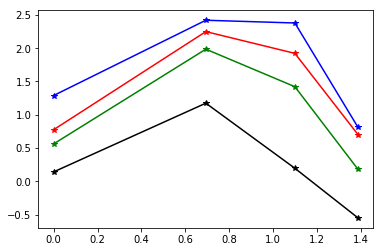

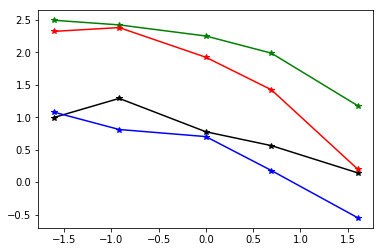

In [170]:
spatial = [1,2,3,4]
freq = [5,2,1,0.4,0.2]
fig1 = plt.figure()
plt.plot(np.log(spatial),np.log(matrix_65[:,0]), 'k*-')#sustained
plt.plot(np.log(spatial),np.log(matrix_65[:,1]), 'g*-')#sustained
plt.plot(np.log(spatial),np.log(matrix_65[:,2]), 'r*-')#sustained
plt.plot(np.log(spatial),np.log(matrix_65[:,3]), 'b*-')#sustained

fig2 = plt.figure()
plt.plot(np.log(freq), np.log(matrix_65[0,:]), 'k*-')
plt.plot(np.log(freq), np.log(matrix_65[1,:]), 'g*-')
plt.plot(np.log(freq), np.log(matrix_65[2,:]), 'r*-')
plt.plot(np.log(freq), np.log(matrix_65[3,:]), 'b*-')

plt.show()

In [155]:
#from matplotlib import cm
spatial =[ [1,2,3,4],
           [1,2,3,4],
           [1,2,3,4],
           [1,2,3,4] ]
freq = [ [5,3,1,0.4],
         [5,3,1,0.4],
         [5,3,1,0.4],
         [5,3,1,0.4], ]
fig3 = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(freq,spatial, matrix_65[:,:4].T)
#plt.gca().invert_xaxis()
plt.show()

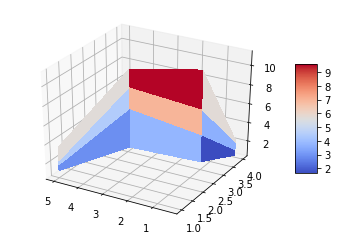

In [169]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(freq, spatial, matrix_65[:,:4].T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.gca().invert_xaxis()
plt.show()

In [152]:
print matrix_65[:,2]
print matrix_65[1,:4]
print matrix_17[1,:4]
column_0 = (matrix_65[:,0]*matrix_65[0,:4])/matrix_17[0,:4]
column_1 = (mdatrix_65[:,1]*matrix_65[0,:4])/matrix_17[0,:4]
column_2 = (matrix_65[:,2]*matrix_65[0,:4])/matrix_17[0,:4]
column_3 = (matrix_65[:,3]*matrix_65[0,:4])/matrix_17[0,:4]
a = np.column_stack((column_0, column_1))
b = np.column_stack((a, column_2))
c = np.column_stack((b, column_3))
print c

[ 2.17177132  9.48797467  6.8410745   2.01613228]
[  3.23490547   7.28558922   9.48797467  11.25655531]
[ 3.5162016   8.10815575  9.93978299  6.42816207]


NameError: name 'mdatrix_65' is not defined

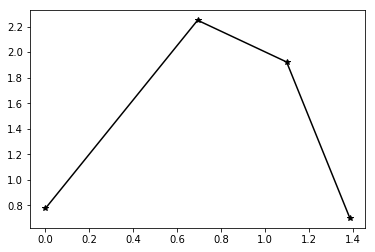

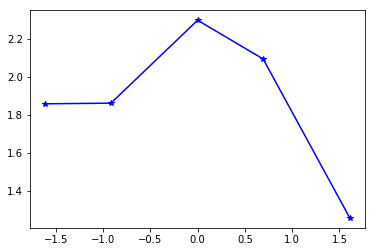

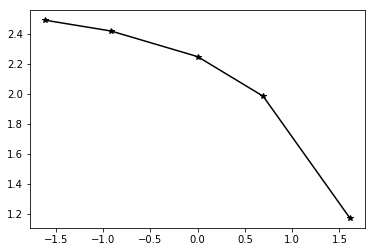

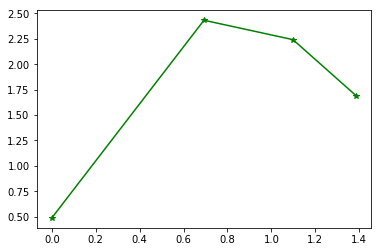

In [57]:
spatial = [1,2,3,4]
freq = [5,2,1,0.4,0.2]
fig1 = plt.figure()
plt.plot(np.log(spatial), np.log(matrix_65[:,2]), 'k*-')#sustained

fig2 = plt.figure()
plt.plot(np.log(freq), np.log(matrix_17[1,:]), 'b*-')#transient

fig3 = plt.figure()
plt.plot(np.log(freq), np.log(matrix_65[1,:]), 'k*-')#sustained

fig4 = plt.figure()
plt.plot(np.log(spatial), np.log(column_2), 'g*-')#desired transient 

plt.show()

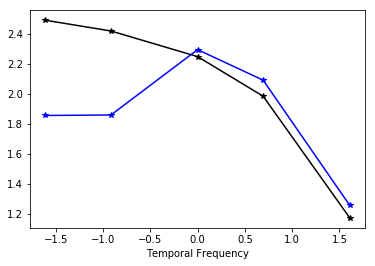

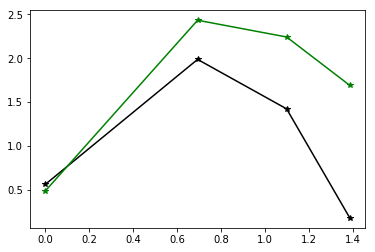

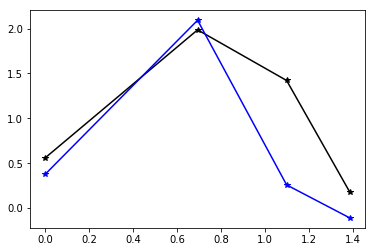

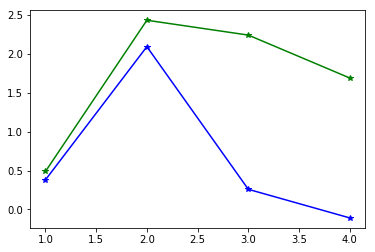

In [58]:
fig5 = plt.figure()
plt.plot(np.log(freq), np.log(matrix_65[1,:]), 'k*-')#sustained
plt.plot(np.log(freq), np.log(matrix_17[1,:]), 'b*-')#transient
#plt.plot(np.log(freq), np.log(matrix_21[1,:]), 'g*-')#MT neuron
plt.xlabel('Temporal Frequency')

fig6 = plt.figure()
plt.plot(np.log(spatial),np.log(matrix_65[:,1]), 'k*-')#sustained
plt.plot(np.log(spatial),np.log(column_2), 'g*-')#transient
#plt.plot(np.log(freq), np.log(matrix_21[1,:]), 'g*-')#MT neuron

fig7 = plt.figure()
plt.plot(np.log(spatial),np.log(matrix_65[:,1]), 'k*-')#sustained
plt.plot(np.log(spatial),np.log(matrix_17[:,1]), 'b*-')#transient
#plt.plot(np.log(freq), np.log(matrix_21[1,:]), 'g*-')#MT neuron

fig8 = plt.figure()
plt.plot((spatial), np.log(matrix_17[:,1]), 'b*-')
plt.plot((spatial), np.log(column_2), 'g*-')

plt.show()

In [25]:
spatial = [1,2,3,4]
freq = [5,2,1,0.4,0.2]
plt.clf
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex = 'row', sharey = 'col')
ax1.plot(np.log(freq), np.log(matrix_17[0,:]), 'g-')
ax2.plot(np.log(freq), np.log(matrix_17[1,:]), 'g-')
ax3.plot(np.log(freq), np.log(matrix_17[2,:]), 'g-')
ax4.plot(np.log(freq), np.log(matrix_17[3,:]), 'g-')
ax1.set_title('Spatial freq = 1')
ax2.set_title('Spatial freq = 2')
ax3.set_title('Spatial freq = 3')
ax4.set_title('Spatial freq = 4')
f.suptitle('Neuron 17 activity in Hz vs temp frequency', fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.82, bottom=0.15, left=0, right=0.95, hspace=0.5,
                    wspace=0.6)
f.text(0.5, 0.04, 'Temporal Frequency (Hz)', ha='center')

f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex = 'row', sharey = 'col')
ax1.plot(np.log(freq), np.log(matrix_65[0,:]), 'g-')
ax2.plot(np.log(freq), np.log(matrix_65[1,:]), 'g-')
ax3.plot(np.log(freq), np.log(matrix_65[2,:]), 'g-')
ax4.plot(np.log(freq), np.log(matrix_65[3,:]), 'g-')
ax1.set_title('Spatial freq = 1')
ax2.set_title('Spatial freq = 2')
ax3.set_title('Spatial freq = 3')
ax4.set_title('Spatial freq = 4')
f.suptitle('Neuron 65 activity in Hz vs temp frequency', fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.82, bottom=0.15, left=0, right=0.95, hspace=0.5,
                    wspace=0.6)
f.text(0.5, 0.04, 'Temporal Frequency (Hz)', ha='center')

f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex = 'row', sharey = 'col')
ax1.plot(np.log(freq), np.log(matrix_21[0,:]), 'g-')
ax2.plot(np.log(freq), np.log(matrix_21[1,:]), 'g-')
ax3.plot(np.log(freq), np.log(matrix_21[2,:]), 'g-')
ax4.plot(np.log(freq), np.log(matrix_21[3,:]), 'g-')
ax1.set_title('Spatial freq = 1')
ax2.set_title('Spatial freq = 2')
ax3.set_title('Spatial freq = 3')
ax4.set_title('Spatial freq = 4')
f.suptitle('Neuron 21 activity in Hz vs temp frequency', fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.82, bottom=0.15, left=0, right=0.95, hspace=0.5,
                    wspace=0.6)
f.text(0.5, 0.04, 'Temporal Frequency (Hz)', ha='center')


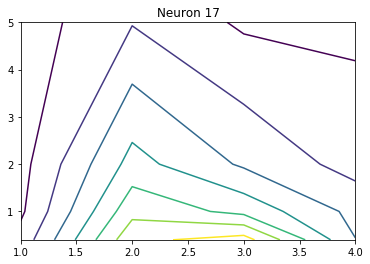

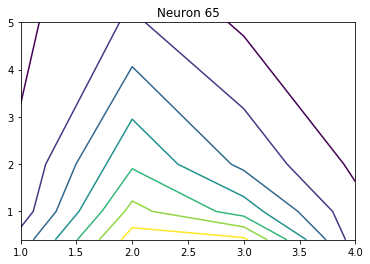

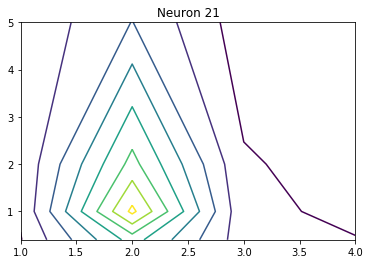

In [59]:
#new_17 = matrix_17[:3,:]
#new_21 = matrix_21[:3,:]
#new_65 = matrix_65[:3,:]

plt.clf()
spatiall = [1,2,3,4]
freq = [5,2,1,0.4]
plt.figure(1)
plt.contour(spatial, freq, c.T)
#plt.axis([0,3,0,6])
plt.title('Neuron 17')


plt.figure(2)
plt.contour(spatial, freq, matrix_65[:,:4].T)
plt.title('Neuron 65')

plt.figure(3)
plt.contour(spatiall, freq,matrix_21[:,:4].T )
plt.title('Neuron 21')

plt.show()

[[ 1.53551571  1.4619992   1.57947005  1.35078206  1.19542849]
 [ 3.5162016   8.10815575  9.93978299  6.42816207  6.40633977]
 [ 0.45593031  1.29535558  1.50906055  1.81434676  1.23622762]
 [ 0.43228021  0.89686514  1.00806614  1.47929782  1.48830727]]
[[  1.15163678   1.75439905   2.17177132   3.63022679   2.7027079 ]
 [  3.23490547   7.28558922   9.48797467  11.25655531  12.09286609]
 [  1.21581416   4.14513786   6.8410745   10.80169232  10.18544059]
 [  0.57637361   1.19582019   2.01613228   2.24853268   2.94117866]]
[[ 0.70080001  1.12174216  1.3351589   1.84891091]
 [ 1.96245707  2.77435568  3.03848253  3.20940801]
 [ 1.06041138  2.28693348  2.78794225  3.24470026]
 [ 0.75394952  1.48378102  2.00612969  2.11522658]]
[[ 0.28768207  0.28768207  0.28768207  0.28768207]
 [ 0.18232156  0.18232156  0.18232156  0.18232156]
 [ 0.31845373  0.31845373  0.31845373  0.31845373]
 [ 0.98861139  0.98861139  0.98861139  0.98861139]]
[[ 0.45575091  0.72950201  0.86829321  1.20240129]
 [ 1.37012325

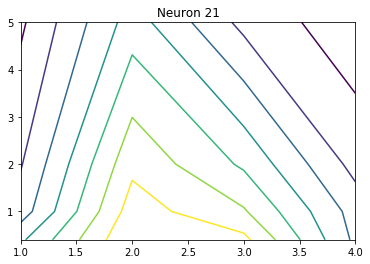

In [60]:
print matrix_17
print matrix_65
matrix_new = np.log(c+matrix_65[:,:4])
print matrix_new
matrix_new_2 = abs(np.log(c)-np.log(matrix_65[:,:4]))
print matrix_new_2
matrix_new_new = (matrix_new)/(matrix_new_2+1.25)
print matrix_new_new

plt.figure(3)
plt.contour(spatiall, freq,matrix_new_new.T )

plt.title('Neuron 21')
plt.show()